
# Project 2 - Classification
## Predict customers likely to respond to a marketing campaign

### MODEL : Decision Forest - LightGBM


### Dataset description


- **RowNumber**: row number.
- **CustomerId**: internal ID of the customer.
- **Surname**: customer's surname.
- **CreditScore**: customers's credit score/rating. The higher the score the better the customer.
- **Geography**: customer’s location.
- **Gender**: customer's gender.
- **Age**: customer's age. A known business fact is that older customers are less likely to leave the bank than younger ones.
- **Tenure**: number of years since the customer has been a client of the bank. Usually, older clients are more loyal and less likely to leave a bank.
- **Balance**: sum of the balances of all accounts of the customer.
- **NumOfProducts**: number of products that a customer has purchased through the bank.
- **HasCrCard**: binary variable indicating whether or not a customer has a credit card.
- **IsActiveMember**: binary variable indicating whether or not a customer is active in having iterations with the bank.
- **EstimatedSalary**: customer's estimated salary.
- **Exited**: binary variable indicating whether or not the customer left the bank (target variable).


More information on the dataset available at https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

### Initial setup and modules/packages loading

In [136]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics
from yellowbrick.classifier import ROCAUC
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve


In [6]:
# Load data 
ds = pd.read_excel('transformed_data2.xlsx', sheet_name='Sheet1')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Education                2240 non-null   object 
 1   Marital_Status           2240 non-null   object 
 2   Income                   2240 non-null   float64
 3   Recency                  2240 non-null   int64  
 4   Purchases_With_Discount  2240 non-null   float64
 5   Visits_Web_LastMonth     2240 non-null   float64
 6   Has_Complained           2240 non-null   int64  
 7   Response                 2240 non-null   int64  
 8   Age                      2240 non-null   int64  
 9   Year                     2240 non-null   int64  
 10  Month                    2240 non-null   int64  
 11  TotalSpent               2240 non-null   float64
 12  TotalAcceptedCampaigns   2240 non-null   int64  
 13  TotalPurchases           2240 non-null   float64
 14  TotalDependents         

In [7]:
# Display top 10 rows
ds.head(10)

,Education,Marital_Status,Income,Recency,Purchases_With_Discount,Visits_Web_LastMonth,Has_Complained,Response,Age,Year,Month,TotalSpent,TotalAcceptedCampaigns,TotalPurchases,TotalDependents
0,Graduation,Single,58138.0,58,0.477121,0.845098,0,1,57,2012,9,12.664460,0,1.060892,0
1,Graduation,Single,46344.0,38,0.301030,0.698970,0,0,60,2014,3,2.120574,0,0.114287,2
2,Graduation,Together,71613.0,26,0.000000,0.602060,0,0,49,2013,8,10.091982,0,0.591409,0
3,Graduation,Together,26646.0,26,0.301030,0.778151,0,0,30,2014,2,4.421604,0,-0.044269,1
4,PhD,Married,58293.0,94,0.698970,0.698970,0,0,33,2014,1,9.514639,0,0.650999,1
5,Master,Together,62513.0,16,0.301030,0.778151,0,0,47,2013,9,8.555788,0,0.761789,1
6,Graduation,Divorced,55635.0,34,0.602060,0.778151,0,0,43,2012,11,10.265112,0,0.671191,1
7,PhD,Married,33454.0,32,0.301030,0.903090,0,0,29,2013,5,5.106123,0,0.080670,1
8,PhD,Together,30351.0,19,0.000000,0.954243,0,1,40,2013,6,3.480582,0,-0.108936,1
9,PhD,Together,5648.0,68,0.000000,1.301030,0,0,64,2014,3,2.225309,1,0.000000,2


In [8]:
# Summary statistics for all variables
ds.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Education,2240,5,Graduation,1127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital_Status,2240,6,Married,864,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Income,2240.0,NaN,NaN,NaN,51944.873599,21490.712077,1730.0,35233.5,51277.0,68413.25,162397.0
Recency,2240.0,NaN,NaN,NaN,49.109375,28.962453,0.0,24.0,49.0,74.0,99.0
Purchases_With_Discount,2240.0,NaN,NaN,NaN,0.267168,0.283446,0.0,0.0,0.30103,0.477121,1.176091
Visits_Web_LastMonth,2240.0,NaN,NaN,NaN,0.663004,0.262617,0.0,0.477121,0.778151,0.845098,1.30103
Has_Complained,2240.0,NaN,NaN,NaN,0.009375,0.096391,0.0,0.0,0.0,0.0,1.0
Response,2240.0,NaN,NaN,NaN,0.149107,0.356274,0.0,0.0,0.0,0.0,1.0
Age,2240.0,NaN,NaN,NaN,45.096875,11.694144,18.0,37.0,44.0,55.0,74.0
Year,2240.0,NaN,NaN,NaN,2013.028125,0.684554,2012.0,2013.0,2013.0,2013.0,2014.0


## Data Preparation

In [9]:
ds['Education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

The **Education** was transformed variable into a numerical format; creating a new variable called **Education_Years**, which represents the number of years of education a person has completed. This was done to avoid the curse of dimensionality.

In [10]:
education_years_map = {
    'Basic': 6,
    '2n Cycle': 9,
    'Graduation': 16,
    'Master': 18,
    'PhD': 21
}

ds['Education_Years'] = ds['Education'].map(education_years_map)

In [11]:
ds.drop(columns=['Education', 'Year', 'Month', 'TotalSpent'], inplace=True)

In [12]:
X = ds

## One Hot Encoding

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Marital_Status           2240 non-null   object 
 1   Income                   2240 non-null   float64
 2   Recency                  2240 non-null   int64  
 3   Purchases_With_Discount  2240 non-null   float64
 4   Visits_Web_LastMonth     2240 non-null   float64
 5   Has_Complained           2240 non-null   int64  
 6   Response                 2240 non-null   int64  
 7   Age                      2240 non-null   int64  
 8   TotalAcceptedCampaigns   2240 non-null   int64  
 9   TotalPurchases           2240 non-null   float64
 10  TotalDependents          2240 non-null   int64  
 11  Education_Years          2240 non-null   int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 210.1+ KB


One-hot encoding is applied before modeling to convert categorical variables into a numerical format that machine learning algorithms can understand. It avoids incorrect assumptions about category order (as in label encoding) by creating separate binary columns for each category, ensuring the model interprets them correctly.

In [14]:
# Encode boolean features into dummy variables
cols = ['Has_Complained']
X = pd.get_dummies(data=X,columns=cols,drop_first=True)

In [15]:
# Encode categorical variables to dummy variables
cols = ['Marital_Status']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Marital_Status_Single    2240 non-null   int64  
 1   Marital_Status_Together  2240 non-null   int64  
 2   Marital_Status_Married   2240 non-null   int64  
 3   Marital_Status_Divorced  2240 non-null   int64  
 4   Marital_Status_Widow     2240 non-null   int64  
 5   Marital_Status_Other     2240 non-null   int64  
 6   Income                   2240 non-null   float64
 7   Recency                  2240 non-null   int64  
 8   Purchases_With_Discount  2240 non-null   float64
 9   Visits_Web_LastMonth     2240 non-null   float64
 10  Response                 2240 non-null   int64  
 11  Age                      2240 non-null   int64  
 12  TotalAcceptedCampaigns   2240 non-null   int64  
 13  TotalPurchases           2240 non-null   float64
 14  TotalDependents         

### Modeling - DF

In [17]:
# Create the Target
y = X['Response']

In [18]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=123)

In [19]:
# Remove the Target from the training
X_train = X_train.drop(['Response'],axis=1)
X_test = X_test.drop(['Response'],axis=1)

In [20]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 560 entries, 794 to 1635
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Marital_Status_Single    560 non-null    int64  
 1   Marital_Status_Together  560 non-null    int64  
 2   Marital_Status_Married   560 non-null    int64  
 3   Marital_Status_Divorced  560 non-null    int64  
 4   Marital_Status_Widow     560 non-null    int64  
 5   Marital_Status_Other     560 non-null    int64  
 6   Income                   560 non-null    float64
 7   Recency                  560 non-null    int64  
 8   Purchases_With_Discount  560 non-null    float64
 9   Visits_Web_LastMonth     560 non-null    float64
 10  Age                      560 non-null    int64  
 11  TotalAcceptedCampaigns   560 non-null    int64  
 12  TotalPurchases           560 non-null    float64
 13  TotalDependents          560 non-null    int64  
 14  Education_Years          560

Counter({0: 1429, 1: 251})
Response
0    0.850595
1    0.149405
Name: proportion, dtype: float64


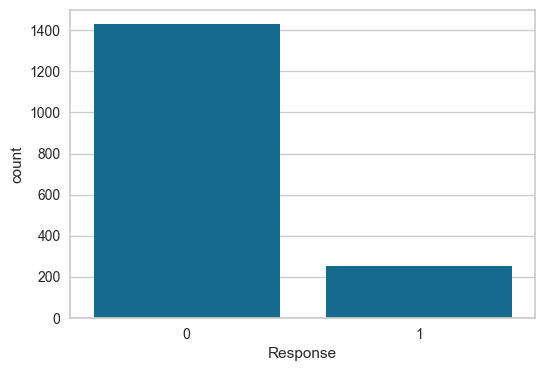

In [21]:
# Display target balance in the training dataset
print(collections.Counter(y_train))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="Response", data=pd.DataFrame(data={'Response':y_train}), ax=ax)
print(y_train.value_counts(normalize=True))

In [22]:
# Create the LightGBM classifier
lgbm_model = lgb.LGBMClassifier(random_state=42)

In [23]:
# Define SMOTE for handling class imbalance
smote = SMOTE(random_state=123, sampling_strategy=1)

In [82]:
# Feature selector using RFE
selector = RFE(estimator=lgbm_model)

In [83]:
pipeline = Pipeline([
    ('smote', smote),                    # Handle class imbalance
    ('feature_selection', selector),    # Select best features
    ('classifier', lgbm_model)          # Final model
])

In [102]:
# Define parameter grid for RandomizedSearchCV (you can adjust based on your needs)
param_grid = {

        # Feature Selection
    'feature_selection__n_features_to_select': [6, 8, 10, 12, 14, 16],  # Adjust depending on total features

    
    'classifier__n_estimators': [4, 6, 8],
    'classifier__max_depth': [1, 2, 3],
    'classifier__learning_rate': [0.02, 0.03, 0.04, 0.05],
    'classifier__num_leaves': [4, 5, 6],
    'classifier__min_data_in_leaf': [2, 4],
    'classifier__subsample': [0.1, 0.2, 0.3],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],
    'classifier__reg_alpha': [0.1, 0.2, 0.3],
}

In [103]:
# Define Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [104]:
# Setup RandomizedSearchCV with LightGBM
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,  # Number of random combinations to try
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [105]:
# Fit the randomized search
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1429, number of negative: 1429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1200
[LightGBM] [Info] Number of data points in the train set: 2858, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Info] Number of positive: 1429, number of negative: 1429
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('smote',
                                              SMOTE(random_state=123,
                                                    sampling_strategy=1)),
                                             ('feature_selection',
                                              RFE(estimator=LGBMClassifier(random_state=42))),
                                             ('classifier',
                                              LGBMClassifier(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__colsample_bytree': [...
                                        'classifier__learning_rate': [0.02,
                                                                      0.03,
                                                                      0.04,
                                                                      0.05],
                                        'classifier__max_depth': [1, 2, 3],
                                        'classifier__min_data_in_leaf': [2, 4],
                                        'classifier__n_estimators': [4, 6, 8],
                                        'classifier__num_leaves': [4, 5, 6],
                                        'classifier__reg_alpha': [0.1, 0.2,
                                                                  0.3],
                                        'classifier__subsample': [0.1, 0.2,
                                                                  0.3],
                                        'feature_selection__n_features_to_select': [6,
                                                                                    8,
                                                                                    10,
                                                                                    12,
                                                                                    14,
                                                                                    16]},
                   random_state=42, scoring='f1', verbose=2)

In [106]:
# Best model and performance
print("Best params:", random_search.best_params_)
print("Best Precision score:", random_search.best_score_)

Best params: {'feature_selection__n_features_to_select': 16, 'classifier__subsample': 0.2, 'classifier__reg_alpha': 0.3, 'classifier__num_leaves': 6, 'classifier__n_estimators': 6, 'classifier__min_data_in_leaf': 4, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.02, 'classifier__colsample_bytree': 0.7}
Best Precision score: 0.46419166324294603


In [117]:
# You can now use the best estimator to make predictions
best = random_search.best_estimator_
y_pred = best.predict(X_test.values)

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Evaluation - DF

In [118]:
# predict y for X_train and X_test
y_pred_train = best.predict(X_train.values) 
y_pred_test = best.predict(X_test.values) 

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [119]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, y_pred_custom):
  measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain),
                metricsObj.f1_score(yTrain, yPredTrain),
                metricsObj.roc_auc_score(yTrain, yPredTrain)
                ]
  test_results = [metricsObj.accuracy_score(yTest, y_pred_custom),
               metricsObj.precision_score(yTest, y_pred_custom),
               metricsObj.recall_score(yTest, y_pred_custom),
               metricsObj.f1_score(yTest, y_pred_custom),
               metricsObj.roc_auc_score(yTest, y_pred_custom)
               ]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [120]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

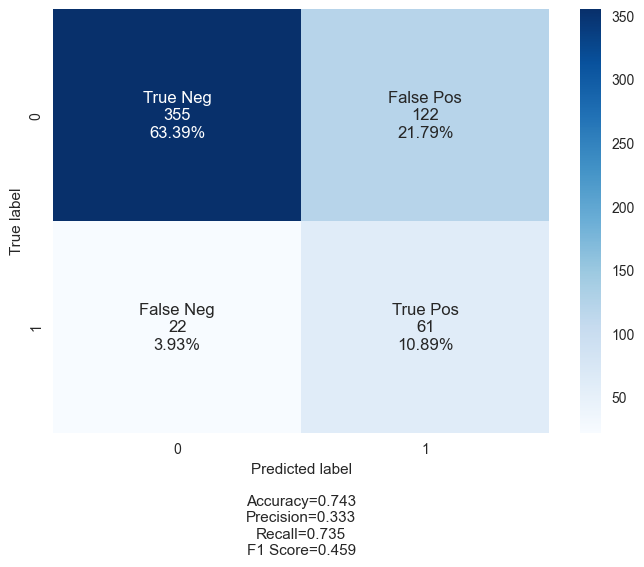

In [121]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [122]:
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.749405,0.742857
1,PRECISION,0.344891,0.333333
2,RECALL,0.752988,0.734940
3,F1 SCORE,0.473091,0.458647
4,AUC,0.750882,0.739587


C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feat

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


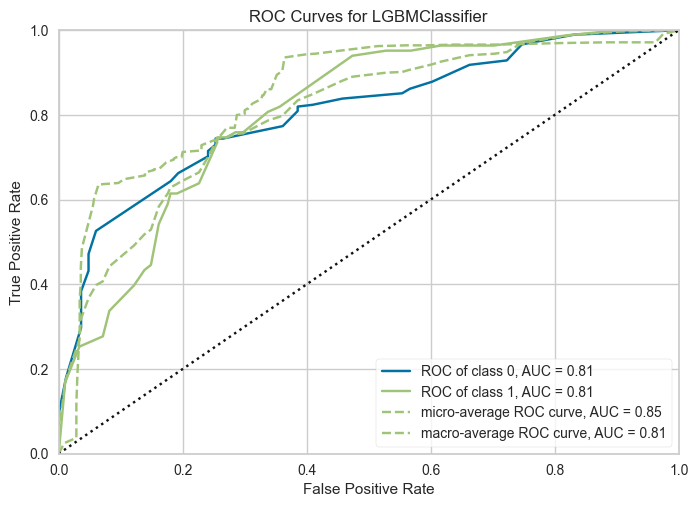

<Axes: title={'center': 'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [123]:
# ROC curve
visualizer = ROCAUC(best, classes=['0','1'])
visualizer.fit(X_train.values, y_train)
visualizer.score(X_test.values, y_test)
visualizer.show()

## Tuning with treshold adjusting 

In [124]:
thresholds = np.arange(0.0, 1.01, 0.01)

In [125]:
# Get predicted probabilities from your trained pipeline
y_proba = best.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [126]:
profits = []
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    TP = np.sum((y_test == 1) & (y_pred == 1))
    FP = np.sum((y_test == 0) & (y_pred == 1))
    
    revenue = 11 * TP
    cost = 3 * (TP + FP)
    net_profit = revenue - cost
    profits.append(net_profit)

# Find threshold with max profit
best_threshold = thresholds[np.argmax(profits)]
max_profit = np.max(profits)

print(f"Best threshold for max profit: {best_threshold:.3f} (Profit: {max_profit}€)")

Best threshold for max profit: 0.500 (Profit: 122€)


In [140]:
# Apply your custom threshold
custom_threshold = 0.50  # You can tune this
y_pred_custom = (y_proba >= custom_threshold).astype(int)

C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


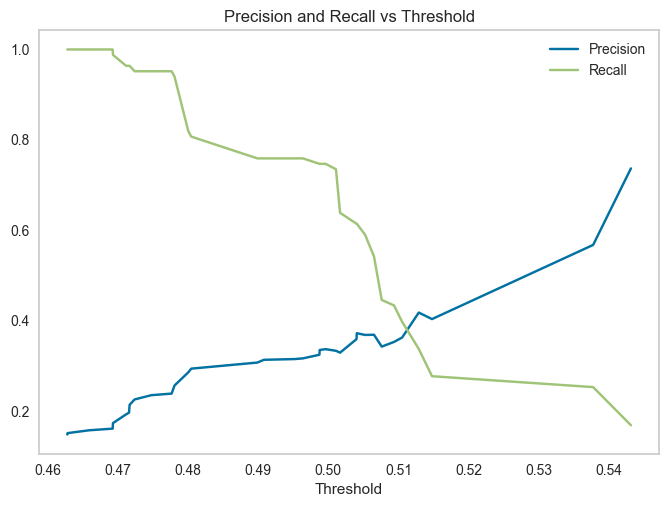

In [141]:
y_scores = best.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.title('Precision and Recall vs Threshold')
plt.grid()
plt.show()

### Interpretation

In [149]:
# Fit pipeline
pipeline.fit(X_train, y_train)


C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1429, number of negative: 1429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1200
[LightGBM] [Info] Number of data points in the train set: 2858, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1429, number of negative: 1429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1200
[LightGBM] [Info] Number of data points in the train set: 2858, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1429, number of negative: 1429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

Pipeline(steps=[('smote', SMOTE(random_state=123, sampling_strategy=1)),
                ('feature_selection',
                 RFE(estimator=LGBMClassifier(random_state=42))),
                ('classifier', LGBMClassifier(random_state=42))])

In [150]:
# Access model from pipeline
lgb_model = pipeline.named_steps['classifier']

In [151]:
# If you used feature selection, get selected feature names
selector = pipeline.named_steps.get('feature_selection')
if selector:
    selected_features = X_train.columns[selector.get_support()]
else:
    selected_features = X_train.columns

In [154]:
# Get feature importances
importance = lgb_model.booster_.feature_importance(importance_type='gain')
importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

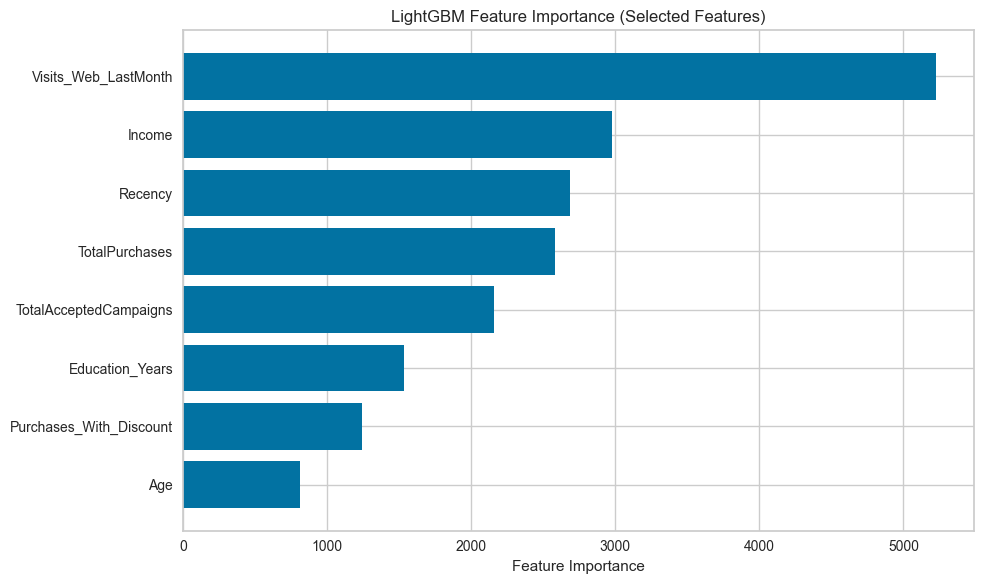

In [155]:
# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importance (Selected Features)')
plt.tight_layout()
plt.show()

### Evaluation

In [142]:
# predict y for X_train and X_test
y_pred_train = best_rf.predict(X_train) 
y_pred_test = best_rf.predict(X_test) 

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [143]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, y_pred_custom):
  measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain),
                metricsObj.f1_score(yTrain, yPredTrain),
                metricsObj.roc_auc_score(yTrain, yPredTrain)
                ]
  test_results = [metricsObj.accuracy_score(yTest, y_pred_custom),
               metricsObj.precision_score(yTest, y_pred_custom),
               metricsObj.recall_score(yTest, y_pred_custom),
               metricsObj.f1_score(yTest, y_pred_custom),
               metricsObj.roc_auc_score(yTest, y_pred_custom)
               ]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [144]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

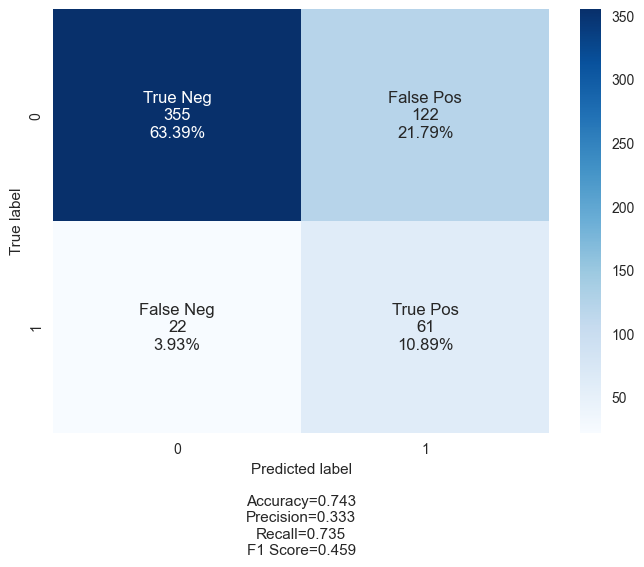

In [145]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_custom)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [146]:
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_custom)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.749405,0.742857
1,PRECISION,0.344891,0.333333
2,RECALL,0.752988,0.734940
3,F1 SCORE,0.473091,0.458647
4,AUC,0.750882,0.739587


C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


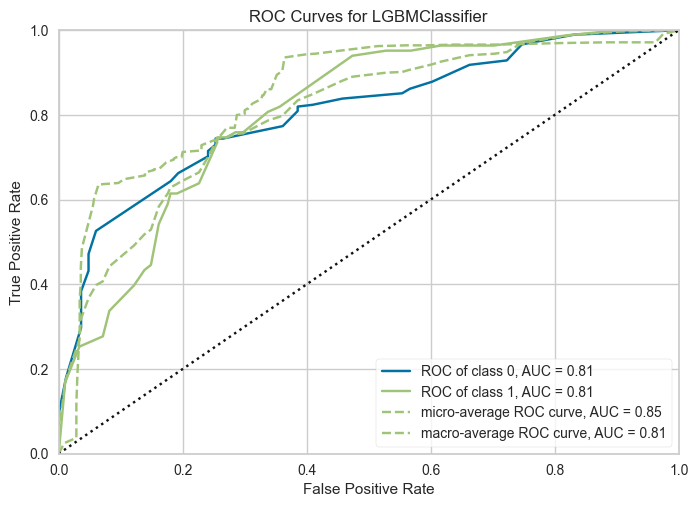

<Axes: title={'center': 'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [147]:
# ROC curve
visualizer = ROCAUC(best_rf, classes=['0','1'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()